# Práctico 3 - Introducción al Aprendizaje Automático

## Modelos de Precios de Mercado
Queremos crear un modelo que prediga si el precio de una acción va a subir o bajar de acuerdo a información del pasado. Para ello implementaremos algunos modelos derivados de la teoria económica respecto de como valuar una activo con flujo de fondos inciertos.


### Capital Asset Pricing Model (CAPM)

El modelo de CAPM propuesto por William Sharpe a partir del desarrollo de Markowitz sobre carteras eficientes, busca predecir el retorno de un activo en función del comportamiento global del mercado, y de la relación del activo puntual con el mercado. 

Según este modelo, que se puede expresar de la siguiente manera: 

$$
E(r_i) = r_f + \beta  [ E(r_m) - r_f ] 
$$

El retorno esperado del activo i, es igual al retorno libre de riesgo (o tasa libre de riesgo), más el exceso de retorno esperado de mercado (es decir lo que se espera que rinda el mercado por sobre la tasa libre de riesgo) escalado por un coeficiente beta. Este coeficiente beta es el conciente entre la covarianza del activo con el mercado sobre la varianza del mercado, y se interpreta como un multiplicador de riesgo de mercado.

Pueden ver una explicación completa en: https://economipedia.com/definiciones/modelo-valoracion-activos-financieros-capm.html

Adicionalmente, se puede agregar un término independiente como ordenada al origen alfa, que represanta una ganancia extraordinaria no explicada por la relacion con de la acción con el mercado sino por factores extraordinarios o arbitrages en caso de estrategias. De allí el famoso "buscar alfa" siendo una directriz de todos los portafolios managers. 

$$
E(r_i) = \alpha + r_f + \beta  [ E(r_m) - r_f ]
$$

Para realizar este ejercicio, deberán descargar el precio de una acción y del mercado asociado (por ejemplo GOOG y NASDAQ). En ambos casos tomar los retornos y tomar una tasa libre de riesgo. A continuación, deberán probar varias regresiones para comprobar el beta, y examinar si el agregado de una ordenada al origen aporta a los resultados. La idea es que seleccionen varias acciones para modelarlo con diferentes activos. 

Una vez que lo hayan hecho, adionalmente responder las siguientes preguntas:

1. ¿Es fácil encontrar $\alpha$ distinto de cero?

2. ¿Qué interpretación le podemos dar a $\beta$?

3. ¿En qué momento nos gustaría buscar activos con $\beta$ > 1 y $\beta$ < 1? ¿Qué implica tener un $\beta$ < 0?



1.  

2. Beta de un activo financiero: Medida de la sensibilidad del activo respecto a su Benchmark. La interpretación de este parámetro nos permite conocer la variación relativa de la rentabilidad del activo respecto al mercado en que cotiza.
La beta se puede calcular a través de una regresión entre la rentabilidad del activo y del mercado. 

3. 

- Si la beta se encuentra entre cero y uno, se trataría de un activo defensivo ya que es menos arriesgado que el mercado. Cuando el mercado sube, el activo lo hace con menor intensidad, y viceversa.

- Para la cartera de mercado, la beta es igual uno, moviéndose a la par que el índice o benchmark. 

- En el caso de tener títulos agresivos con beta superior a uno significa que el activo o cartera se mueve en mayor proporción que el benchmark, tanto al alza como a la baja.

- Que la beta sea igual a cero quiere decir que la covarianza del activo con respecto al mercado es cero. Esto ocurriría con el activo libre de riesgo, por ejemplo. 

-  Una beta menor que cero, su covarianza es negativa, se refiere a los títulos cuya correlación con el mercado es inversa. Se trata de activos refugio como por ejemplo el Oro.


opcion mas facil

- cero: indica que no hay correlación con el índice de referencia elegido (por ejemplo, índice NASDAQ)
- uno: indica que una acción tiene la misma volatilidad que el mercado
- más de uno:  indica una acción que es más volátil que su índice de referencia
- menos de uno: es menos volátil que el índice de referencia


### 0) Importación de librerías

In [54]:
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf # Agrego esto # pip install yfinance --upgrade --no-cache-dir
import numpy as np # Agrego esto
import seaborn as sns
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression

### 1) Download dataframe

In [2]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df = pdr.get_data_yahoo("KO NYA", start=start_date, end=end_date)
df_ndaq = pdr.get_data_yahoo("NDAQ GOOG FB AMZN", start=start_date, end=end_date)


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed


In [3]:
df.isna().sum()

Adj Close  KO       0
           NYA    321
Close      KO       0
           NYA    321
High       KO       0
           NYA    321
Low        KO       0
           NYA    321
Open       KO       0
           NYA    321
Volume     KO       0
           NYA    321
dtype: int64

In [4]:
data_respaldo = df
df.dropna(inplace=True)

### 2) Determinación de retornos totales

In [5]:
df['retornos_ko'] = df['Adj Close', 'KO'].pct_change()*100
df['retornos_nya'] = df['Adj Close','NYA'].pct_change()*100
df.head()

Adj Close                  Close                   High  \
                   KO          NYA        KO          NYA        KO   
Date                                                                  
2000-01-03  15.690016  6762.109863  28.18750  6762.109863  29.00000   
2000-01-04  15.707405  6543.759766  28.21875  6543.759766  28.40625   
2000-01-05  15.846567  6567.029785  28.46875  6567.029785  28.71875   
2000-01-06  15.863964  6635.439941  28.50000  6635.439941  28.84375   
2000-01-07  16.907639  6792.669922  30.37500  6792.669922  30.37500   

                              Low                   Open               \
                    NYA        KO          NYA        KO          NYA   
Date                                                                    
2000-01-03  6762.109863  27.62500  6762.109863  29.00000  6762.109863   
2000-01-04  6543.759766  27.81250  6543.759766  28.18750  6543.759766   
2000-01-05  6567.029785  28.03125  6567.029785  28.21875  6567.029785   
2000-01-06  6635.439941  28.28125  6635.439941  28.46875  6635.439941   
2000-01-07  6792.669922  28.93750  6792.669922  28.93750  6792.669922   

              Volume      retornos_ko retornos_nya  
                  KO  NYA                           
Date                                                
2000-01-03  10997000  0.0         NaN          NaN  
2000-01-04   7308000  0.0    0.110830    -3.229023  
2000-01-05   9457400  0.0    0.885965     0.355606  
2000-01-06   7129200  0.0    0.109784     1.041721  
2000-01-07  11474000  0.0    6.578901     2.369549

In [6]:
df_retornos = pd.concat([df['retornos_ko'], df['retornos_nya']], axis=1, keys=['retornos_ko', 'retornos_nya'])

# Reseteo MultiIndex y renombro columnas
df_retornos = df_retornos.reset_index(level='Date') # Reseteo MultiIndex (Date en este caso y la guardaré como columna)v

df_retornos.dropna(inplace=True) # descarto fechas en que tengo NaN en algún retorno
df_retornos.head()

,Date,retornos_ko,retornos_nya
1,2000-01-04,0.110830,-3.229023
2,2000-01-05,0.885965,0.355606
3,2000-01-06,0.109784,1.041721
4,2000-01-07,6.578901,2.369549
5,2000-01-10,-3.189248,0.673966


El dataset `df_retornos` sera el dataset de `train + test`

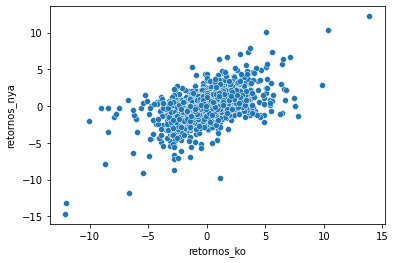

In [7]:
ax = sns.scatterplot(data=df_retornos, x='retornos_ko', y='retornos_nya')

$$ E(r_i) = \alpha + r_f + \beta  [ E(r_m) - r_f ]  $$

- E(r_i): rentabilidad esperada del activo
- alpha: ordenada al origin: representa una ganancia extraordinaria
- r_f: rentabilidad activo sin riesgo (riskfree)
- beta: sensibilidad del activo respecto a su benchmark (correlacion entre los retornos del activo y del mercado)
- E(r_m): tasa rentabilidad esperada del mercado en el que cotiza el activo

- r_m - r_f : riesgo asociado al mercado en el que cotiza el activo
- r_i -  r_f : riesgo asociado al activo en concreto

$$ E(r_i)  - r_f = \alpha + \beta [ E(r_m) - r_f ]  $$
$$ retornos del activo = \alpha + \beta (retornos del mercado) $$
$$ y_i = \alpha + \beta (x_i) $$

### opcion 1 ) Determinación de beta: mediante Statsmodels: Ordinary Least Square (mínimos cuadrados)

In [8]:
# split dependent and independent variable
X = df_retornos['retornos_nya']
y = df_retornos['retornos_ko']

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            retornos_ko   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     2059.
Date:                Sun, 22 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:44:29   Log-Likelihood:                -7787.3
No. Observations:                4961   AIC:                         1.558e+04
Df Residuals:                    4959   BIC:                         1.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0206      0.017      1.246   

El beta calculado mediante Statsmodels: Ordinary Least Square arroja un resultado de: Beta = 0,5790

In [26]:
df_ret = pd.concat([df['retornos_ko'], df['retornos_nya']], axis=1, keys=['retornos_ko', 'retornos_nya'])

In [28]:
df_ret = df_ret.replace(np.nan, 0)
df_ret.head()

,retornos_ko,retornos_nya
Date,,
2000-01-03,0.000000,0.000000
2000-01-04,0.110830,-3.229023
2000-01-05,0.885965,0.355606
2000-01-06,0.109784,1.041721
2000-01-07,6.578901,2.369549


In [35]:
# TimeSeriesSplit
X = df_ret['retornos_nya']
y = df_ret['retornos_ko']


tscv = TimeSeriesSplit(n_splits=2)
# print(tscv) # TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LinearRegression()
    lr.fit(X_train.values.reshape(-1, 1), y_train)
    print(f' el beta es igual a: {lr.coef_}')
    

Fold: 0
TRAIN indices: [   0    1    2 ... 1651 1652 1653] 
 TEST indices: [1654 1655 1656 ... 3305 3306 3307]


 el beta es igual a: [0.55138433]
Fold: 1
TRAIN indices: [   0    1    2 ... 3305 3306 3307] 
 TEST indices: [3308 3309 3310 ... 4959 4960 4961]


 el beta es igual a: [0.52828159]


In [36]:
df_ndaq['retornos_ndaq'] = df['Adj Close', 'NDAQ'].pct_change()*100
df_ndaq['retornos_goog'] = df['Adj Close','GOOG'].pct_change()*100
df_ndaq['retornos_fb'] = df['Adj Close','FB'].pct_change()*100           
df_ndaq['retornos_amzn'] = df['Adj Close','AMZN'].pct_change()*100

KeyError: ('Adj Close', 'NDAQ')

### Graficación

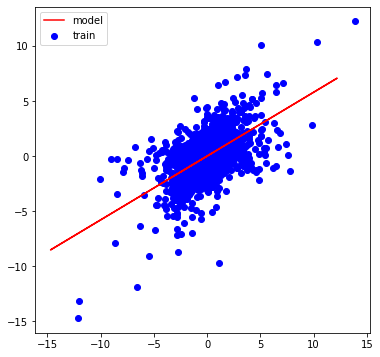

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(data=df_retornos, x='retornos_ko', y='retornos_nya', color="blue", label='train')
plt.plot(x_i, y_i_pred, color='red', label='model')
plt.legend()

In [ ]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_val, y_val, color="white", edgecolor="k", label="validation")
plt.plot(X_val, f(X_val, w), color="red", label="model")
plt.legend()
plt.show()

### Evaluación en entrenamiento: Error Cuadrático Medio

Se obtienen los valores predichos para los datos de entrenamiento y de validación. Calcularemos el error cuadrático medio sobre ambos conjuntos de datos. Luego haremos la predicción sobre el conjunto de testeo y calcularemos también el erro cuadrático medio.



In [ ]:
y_train_pred = f(X_train, w, add_bias=False)
y_val_pred = f(X_val, w, add_bias=False)

In [ ]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_val_pred)
print(f'Train error: {train_error:f}')
print(f'Val error: {val_error:f}')

### Predicción y evaluación: Error Cuadrático Medio

In [ ]:
y_train_pred = f(X_train, w, add_bias=False)
y_test_pred = f(X_test, w, add_bias=False)

In [ ]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:f}')
print(f'Val error: {test_error:f}')

In [ ]:
# CONSULTAR POR QUE DAN IGUAL??? ESTÁ BIEN PLANTEADO CONCEPTUALMENTE EL CALCULO DE ERROR DE VALIDACION Y TEST???

### Modelos Autorregresivos para predecir precios.

Para esta parte del práctico, nos gustaría utilizar precios del pasado para poder estimar cuál va a ser el precio de una acción más adelante. Las regresiones que vemos en la introducción al aprendizaje automático no son las mismas que deben usarse cuando estamos trabajando con precios de mercado, ya que estos datos son series de tiempo. Para trabajar con este tipo de datos, es necesario generar **modelos autorregresivos**.

Si suponemos que $y_t$ es el precio de nuestra acción en el tiempo $t$, podemos generar el siguiente modelo autorregresivo:

$$
y_t = \delta + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

Existen otras variables que podemos agregar (como estacionariedad o tendencias), pero para este práctico podemos usar solamente el modelo `AutoReg` de la librería StatsModels: https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html.

El **ejercicio** para esta sección es crear una función que reciba 4 parámetros:
- El *ticker* de un activo.
- Una *fecha* a partir de la cual se van a querer predecir los precios del activo.
- Un *número de días* hacia atrás que se van a usar para ajustar el modelo autorregresivo.
- Un *número de días* hacia adelante para los cuales van a querer predecir el precio del activo utilizando el modelo entrenado.

Esta función se debe encargar de buscar los precios del ticker, realizar el ajuste y predecir el precio de la acción hacia delante. Además, debe devolver el [error cuadrático medio](https://es.wikipedia.org/wiki/Error_cuadr%C3%A1tico_medio) de la predicción, comparado con los verdaderos precios del activo.

¿Qué pasa si tratamos de predecir el precio del SPY el día antes del primer cisne negro de 2020 con un modelo que use 15 días hacia atrás?

### 0) Importación de datos

In [ ]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df = pdr.get_data_yahoo("SPY", start=start_date, end=end_date)

df.head(10)

### 1) Preparación de datos

Como lo que se quiere es predecir el precio `Adj Close` en base a valores del pasado, se trabaja sobre los precios del activo y no sobre el espacio de retornos (pct_change).

In [ ]:
prices = df[['Adj Close']]
# prices = prices.asfreq(freq ='D', fill_value = .0) # Ver si esto es necesario o no. Rellena valores faltantes (fines de semana) con 0.

prices.reset_index(level='Date', inplace=True)
prices.set_index('Date')

prices.head(10)

### 2) Chequeo rápido de autocorrelación

Hay una verificación visual rápida que podemos hacer para ver si hay una autocorrelación en nuestro conjunto de datos de series de tiempo.

Podemos graficar la observación en el paso de tiempo anterior (t-1) con la observación en el siguiente paso de tiempo (t + 1) como un diagrama de dispersión.

Esto se puede hacer manualmente creando primero una versión de retraso (shift) del conjunto de datos de series de tiempo y usando una función de diagrama de dispersión incorporada en la biblioteca de Pandas.

Pero hay una manera más fácil. Pandas proporciona una gráfica incorporada para hacer exactamente esto, llamada función lag_plot ().

In [ ]:
from pandas.plotting import lag_plot

plt.figure(figsize=(8, 8))
lag_plot(prices['Adj Close'])
plt.show()

A simple vista puede observarse una correlación entre los datos. Numéricamente, esto puede cuantificarse mediante el coeficiente Pearson, que se determina a contninuación.

In [ ]:
corr_data = pd.concat([prices['Adj Close'].shift(1), prices['Adj Close']], axis=1)
corr_data.columns = ['t-1', 't+1']
result = corr_data.corr()
print(result)

Se observa una alta correlación positiva (0.999)

### 3) Modelo

### Separación de conjuntos train y test

In [ ]:
print('Fecha máxima y mínima:')
prices.Date.min(), prices.Date.max()

In [ ]:
print('Cantidad de días:' , prices.shape[0])

In [ ]:
# train: n días antes del conjunto train separado en una fecha fijada
# test: n días posteriores del conjunto test separado en la misma fecha fijada

date_split = "2020-01-01" # ingresar fecha de separación
n_back = 15 # días atrás para definir fecha de inicio de data_train (no es la cantidad de datos)
n_forward = 7 # días adelante para definir fecha de fin data_test (no es la cantidad de datos)

data_train = prices.loc[(prices.Date <= str(date_split))]
data_test = prices.loc[(prices.Date > str(date_split))]

limit_train_date = (pd.to_datetime(data_train.Date).max()-timedelta(days=n_back)).date()
limit_test_date = (pd.to_datetime(data_test.Date).min()+timedelta(days=n_forward)).date()
print(limit_train_date, limit_test_date)

# Redefino data_train y data_test
data_train = data_train.loc[(data_train.Date > str(limit_train_date)) & (data_train.Date <= str(date_split))]
data_test = data_test.loc[(data_test.Date > str(date_split)) & (data_test.Date <= str(limit_test_date))]

print('Tamaños data_test:', data_train.shape[0], ', data_val:' , data_test.shape[0])
data_train.head()

Se observa que asignar un número muy grande a `n_back` genera overfitting en el modelo y la predicción tiene mucho error. El orden de `n_back` debe ser similar al valor de `n_forward`.

### Entrenamiento

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html

from statsmodels.tsa.ar_model import AutoReg

values_train = data_train['Adj Close'].values
values_test = data_test['Adj Close'].values

n_lags = 3 # CONSULTAR QUÉ ES ESTE PARÁMETRO

model = AutoReg(values_train, lags=n_lags, old_names=False)
model_fit = model.fit()
# print(model_fit.summary())

In [ ]:
print('Coefficients: %s' % model_fit.params)

### Predicción

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = model_fit.predict(start=len(values_train), end=len(values_train)+len(values_test)-1, dynamic=False)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], values_test[i]))

rmse = sqrt(mean_squared_error(values_test, predictions))

print('Test RMSE: %.3f' % rmse)

### 4) Graficación

In [ ]:
plt.plot(data_test.Date, values_test)
plt.plot(data_test.Date, predictions, color='red')
plt.xlabel("days_predicted")
plt.ylabel("Adj Close")
plt.show()

In [ ]:
# Diagnóstico

fig = plt.figure(figsize=(16,9))
fig = model_fit.plot_diagnostics(fig=fig, lags=n_lags)

### 5) PENDIENTE: ARMAR FUNCIÓN QUE HAGA TODO ESTE PROCESO

### Árboles de Decisión para predecir suba o baja.

Venimos trabajando los precios con valores continuos, pero otra forma de verlos podría ser convirtiendolos en, por ejemplo, -1 y 1 para saber si el precio está en suba o en baja. De esta forma obtenemos un problema de clasificación que nos permite mirar los datos desde otra perspectiva.

- Etiqueten los datos con 1 si [pct_change](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) es mayor a cero y 0, -1 si no.
- Entrenen un árbol de decisión que prediga si el valor de un activo va a subir o bajar.
- Reporten las siguientes métricas sobre el modelo resultante.

    - Accuracy
    - Precision
    - Recall
    - F1
    - matriz de confusión

### 0) Importación de datos

In [43]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df_ko = pdr.get_data_yahoo("KO", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


### 1) Preparación de datos

In [44]:
# Retornos unitarios en 'Adj Close'
df_ko['returns'] = df_ko['Adj Close'].pct_change().shift(-1)
df_ko.head(3)

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2000-01-03,29.00000,29.00000,27.62500,28.18750,15.690016,10997000,0.001108
2000-01-04,28.18750,28.40625,27.81250,28.21875,15.707405,7308000,0.008860
2000-01-05,28.21875,28.71875,28.03125,28.46875,15.846567,9457400,0.001098


In [53]:
df_ko.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
returns      1
target       0
dtype: int64

In [45]:
# Etiquetado
df_ko['target'] = df_ko['returns'].apply(lambda x: 0 if x <= 0 else 1)
df_ko

,Open,High,Low,Close,Adj Close,Volume,returns,target
Date,,,,,,,,
2000-01-03,29.000000,29.000000,27.625000,28.187500,15.690016,10997000,0.001108,1
2000-01-04,28.187500,28.406250,27.812500,28.218750,15.707405,7308000,0.008860,1
2000-01-05,28.218750,28.718750,28.031250,28.468750,15.846567,9457400,0.001098,1
2000-01-06,28.468750,28.843750,28.281250,28.500000,15.863964,7129200,0.065789,1
2000-01-07,28.937500,30.375000,28.937500,30.375000,16.907639,11474000,-0.031892,0
...,...,...,...,...,...,...,...,...
2020-12-23,52.950001,53.389999,52.939999,53.080002,52.248150,7040300,0.006782,1
2020-12-24,53.020000,53.549999,53.020000,53.439999,52.602509,3265500,0.013473,1
2020-12-28,53.849998,54.439999,53.730000,54.160000,53.311226,9020500,-0.000554,0


In [46]:
df_ko['target'].value_counts()

1    2705
0    2578
Name: target, dtype: int64

In [ ]:
# Normalización: divido todos los valores por el primer valor de primera fila
#data.loc[:] = data.loc[:].div(df.iloc[0][:])
#data.head()

### 2) Modelo

Fold: 0
TRAIN indices: [   0    1    2 ... 1758 1759 1760] 
 TEST indices: [1761 1762 1763 ... 3519 3520 3521]


Reporte de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       905
           1       1.00      1.00      1.00       856

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Reporte de test
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       832
           1       0.54      0.50      0.52       929

    accuracy                           0.52      1761
   macro avg       0.52      0.52      0.52      1761
weighted avg       0.52      0.52      0.52      1761

matriz de confusion test
[[447 385]
 [468 461]]
matriz de confusion test
Fold: 1
TRAIN indices: [   0    1    2 ... 3519 3520 3521] 
 TEST indices: [3522 3523 3524 ... 5280 5281 5282]


Reporte de tra

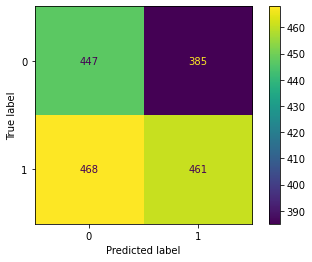

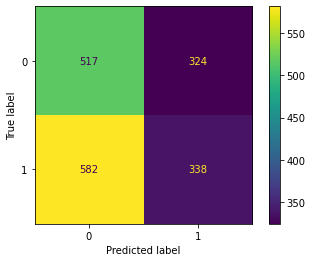

In [59]:
# TimeSeriesSplit
X_ko = df_ko[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_ko = df_ko['target']


tscv = TimeSeriesSplit(n_splits=2)
# print(tscv) # TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

for fold, (train_index, test_index) in enumerate(tscv.split(X_ko)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train_ko, X_test_ko = X_ko.iloc[train_index], X_ko.iloc[test_index]
    y_train_ko, y_test_ko = y_ko.iloc[train_index], y_ko.iloc[test_index]
    # entrenar el modelo
    clf = DecisionTreeClassifier(random_state=100)
    clf.fit(X_train_ko, y_train_ko)
    # predicción
    y_train_pred = clf.predict(X_train_ko)
    y_test_pred = clf.predict(X_test_ko)
    # Evaluar
    print("Reporte de train")
    print(classification_report(y_train_ko, y_train_pred))
    print("Reporte de test")
    print(classification_report(y_test_ko, y_test_pred))
    # Matriz de confusión
    cm=confusion_matrix(y_test_ko, y_test_pred)
    print('matriz de confusion test')
    print(cm)
    print('matriz de confusion test')
    plot_confusion_matrix(clf, X_test_ko, y_test_ko)

Label:

- 1 = etiqueta positiva
- 0 = etiqueta negativa

### Fold 0
Según el modelo, 447 son etiquetas negativas y es correcto. (TP)

385 son etiquets negativas que en realidad son positivas. (FP)

468 son etiquetas positivas que en realidad son negativas. (FN)

461 son etiquetas positivas y es correcto . (TN)



### Fold 1
Según el modelo, 517 son etiquetas negativas y es correcto. (TP)

582 son etiquets negativas que en realidad son positivas. (FP)

324 son etiquetas positivas que en realidad son negativas. (FN)

338 son etiquetas positivas y es correcto . (TN)

El etiquetado de datos no suele ser trivial dado a que depende de la naturaleza de los datos. Posiblemente, el precio de un activo suba un poco pero luego continue su declive ¿Cuánto tiene que subir/bajar un precio para ser considerado "suba"/"baja"?. ¿Tiene sentido tomar "periodos de suba/baja" más grandes para predecir si el comportamiento del activo en el futuro?. ¿Se podría utilizar un enfoque más estadístico para elegir el etiquetado?.

Aplicar GridSearch sobre los parámetros y luego para la mejor configuración encontrada, evaluar sobre el conjunto de entrenamiento y sobre el conjunto de evaluación, reportando:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión